<a href="https://colab.research.google.com/github/hieuza/fun/blob/main/K_mean.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

K-mean algorithm with numpy vectorization.

hieuza@

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# TODO: 
# 1) avoid the empty clusters.

In [3]:
%%time
D = 2
N = 1000 * 1000
K = 20
U = 5  # Number of max updates per trial.
EPS = 0.1
# Iterative approach.
B = 100 * 1000  # Batch size.
E = int(N / B + 1)  # Epoch to loop over whole input data.

points = np.random.rand(N, D)

def compute_distance(points, centroids):
  """Computes distance from each point to each centroid.
  points: shape (N, D).
  centroids: shape (K, D).

  Returns:
    Array of shape (N, K).
  """
  # (N, 1, D) - (1, K, D) --> (N, K, D).
  diff = points[:, None, :] - centroids[None, :, :]
  # Shape: N, K.
  dist = np.linalg.norm(diff, axis=-1)
  return dist


def kmean(points, centroids):
  centroids_hist = [centroids.copy()]
  for _ in range(U):
    # Distance from each point to centroids: shape (N, K).
    dist = compute_distance(points, centroids)

    # Find closest centroids: shape (N, 1).
    closest_idx = np.argmin(dist, axis=1)
    # One-hot: shape (N, K).
    one_hot = np.zeros((points.shape[0], K))
    one_hot[np.arange(points.shape[0]), closest_idx] = 1.0

    # step 1 scatter: (N, 1, D) * (N, K, 1) --> (N, K, D)
    # step 2 compute sum: (N, K, D).sum(axis=0) --> (K, D)
    # step 3 compute mean: (K, D) / (K, 1) --> (K, D)
    centroids = (points[:, None, :] * one_hot[:, :, None]).sum(axis=0) / one_hot.sum(axis=0)[:, None]

    centroids_hist.append(centroids.copy())
    # Centroid changes?
    if (np.sum(np.abs(centroids_hist[-2] - centroids_hist[-1])) < EPS):
      break

  return centroids, centroids_hist, closest_idx


def iterate_kmean(points):
  """Run kmean on batches sampled from points."""
  centroids = points[np.random.choice(range(points.shape[0]), K, replace=False)]
  centroids_hist = []
  for _ in range(E):
    for b in range(0, points.shape[0], B):
      batch = points[b:b+B]
      centroids, h, _ = kmean(batch, centroids)
      centroids_hist.extend(h)

  return centroids, centroids_hist

centroids, centroids_hist = iterate_kmean(points)

CPU times: user 10.5 s, sys: 1.35 s, total: 11.8 s
Wall time: 11.9 s


CPU times: user 615 ms, sys: 42 ms, total: 657 ms
Wall time: 656 ms


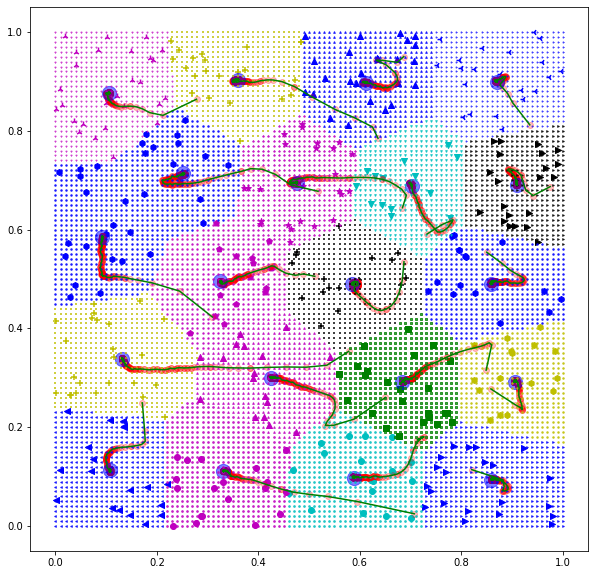

In [5]:
%%time
fig = plt.gcf()
fig.set_size_inches(10, 10)

# Sample about 20 points per class to visualize the input points.
S = 20 * K
colors_all = ['m', 'c', 'k', 'b', 'g', 'y']
markers_all = ['+', '^', 'v', 's', '>', '<', '*', 'h', 'H', '1', '2', '3', '4', '8', 'p', 'o']
colors = [np.random.choice(colors_all) for _ in range(K)]
markers = [np.random.choice(markers_all) for _ in range(K)]

# Draw sample points.
samples = points[np.random.choice(range(N), S)]
dist = compute_distance(samples, centroids)
closest_idx = np.argmin(dist, axis=1)
for kk in range(K):
  plt.scatter(samples[closest_idx == kk, 0], samples[ closest_idx == kk, 1], c=colors[kk], marker=markers[kk])

# Draw the centroid history.
for cc in centroids_hist:
  plt.scatter(cc[:, 0], cc[:, 1], c='r', marker='o', alpha=0.25)
# The final centroids.
plt.scatter(centroids_hist[-1][:, 0], centroids_hist[-1][:, 1], c='b', marker='o', s=200, alpha=0.5)
# The path of the centroids.
for kk in range(K):
  xx = [hh[kk, 0] for hh in centroids_hist]
  yy = [hh[kk, 1] for hh in centroids_hist]
  plt.plot(xx, yy, c='g')

# Draw a grid for all sample 2D point with correct color.
M = 101
xx, yy = np.meshgrid(np.linspace(0, 1, M), np.linspace(0, 1, M))
mesh = np.stack([xx.reshape(-1), yy.reshape(-1)] + [np.zeros_like(yy.reshape(-1))] * (D - 2), axis=1)
mesh_dist = compute_distance(mesh, centroids)
mesh_centroid_idx = np.argmin(mesh_dist, axis=1)

for kk in range(K):
  mm = mesh[mesh_centroid_idx == kk]
  plt.scatter(mm[:, 0], mm[:, 1], c=colors[kk], marker=markers[kk], s=3, alpha=0.75)
